<a href="https://colab.research.google.com/github/chillaks/CSE-534-Project/blob/main/fcn_ids_paper_evaluation_70.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from sklearn import preprocessing, metrics
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer 
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import f_classif, SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from keras.layers import Dense
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model
from keras.utils.vis_utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASETS_DIR = '/content/drive/My Drive/FCN-Project/datasets'
PLOTS_DIR = '/content/drive/My Drive/FCN-Project/plots'

In [ ]:
%cd '/content/drive/My Drive/FCN-Project/datasets' 

/content/drive/My Drive/FCN-Project/datasets


# **Data Preprocessing**

---



In [ ]:
# Import the Train and Test Datasets. Additional information on all features/labels can be found at https://docs.google.com/spreadsheets/d/1oAx320Vo9Z6HrBrL6BcfLH6sh2zIk9EKCv2OlaMGmwY/edit#gid=0
train_data = pd.read_csv('KDDTrain+.txt')
test_data = pd.read_csv('KDDTest+.txt')

train_data.drop(['difficulty_level'], axis=1, inplace=True)
test_data.drop(['difficulty_level'], axis=1, inplace=True)

In [ ]:
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
discrete = ['Wrong Fragment',
'Urgent',
'Count',
'Srv Count',
'Serror Rate',
'Srv Serror Rate',
'Rerror Rate',
'Srv Rerror Rate',
'Same Srv Rate',
'Diff Srv Rate',
'Srv Diff Host Rate',
'Dst Host Count',
'Dst Host Srv Count',
'Dst Host Same Srv Rate',
'Dst Host Diff Srv Rate',
'Dst Host Same Src Port Rate',
'Dst Host Srv Diff Host Rate',
'Dst Host Serror Rate',
'Dst Host Srv Serror Rate',
'Dst Host Rerror Rate',
'Dst Host Srv Rerror Rate',
'Su Attempted']

discrete = [ '_'.join(col.lower().split()) for col in discrete ]


In [ ]:
continuous = ['Duration',
'Src Bytes',
'Dst Bytes',
'Hot',
'Num Failed Logins',
'Num Compromised',
'Num Root',
'Num File Creations',
'Num Shells',
'Num Access Files',
'Num Outbound Cmds']

continuous = [ '_'.join(col.lower().split()) for col in continuous ]


In [ ]:
dropping_nulls =  train_data[continuous + discrete].columns[train_data[continuous + discrete].describe(percentiles=[0.8]).loc['80%'] == 0].to_list()

In [ ]:
train_data.drop(columns=dropping_nulls, inplace= True)

In [ ]:
continuous = [ x for x in continuous if x not in dropping_nulls ]
discrete = [ x for x in discrete if x not in dropping_nulls ]

In [ ]:
discrete

['count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate']

In [ ]:
num_features = 10
fs = SelectKBest(score_func=f_classif, k = num_features)

In [ ]:
train_selected = fs.fit_transform(train_data[discrete], train_data['label'])
train_selected.shape

(125973, 10)

In [ ]:
top_discrete_weights = pd.Series(fs.scores_, index=discrete).sort_values(ascending = False)[:num_features]
top_discrete_weights

same_srv_rate                  40232.920225
dst_host_srv_serror_rate       16715.980137
dst_host_serror_rate           16088.460097
srv_serror_rate                15956.452007
serror_rate                    15785.989942
dst_host_same_srv_rate         11436.901521
dst_host_srv_diff_host_rate     9847.313194
dst_host_srv_count              7911.890531
count                           7379.363178
srv_count                       5979.052315
dtype: float64

In [ ]:
top_discrete = top_discrete_weights.index.to_list()

In [ ]:
categorical_cols = [ 'protocol_type', 'service', 'flag' ]
my_cols = top_discrete + continuous + categorical_cols

In [ ]:
service_values = train_data.service.value_counts()
service_values = service_values[service_values > 500].index.to_list()
train_data = train_data[train_data['service'].isin(service_values)]
test_data = test_data[test_data['service'].isin(service_values)]

In [ ]:
# The above attack sub-classes can be categorized into 4 main classes: DoS, Probe, R2L and U2R. 
# More details on this classification can be found at https://towardsdatascience.com/a-deeper-dive-into-the-nsl-kdd-data-set-15c753364657
def label_preprocessing(data):
  data['label'].replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop',
                              'udpstorm','worm'], 'DoS', inplace=True)
  data['label'].replace(['ipsweep','mscan','nmap','portsweep','saint','satan'], 'Probe', inplace=True)
  data['label'].replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
          'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'], 'R2L', inplace=True)
  data['label'].replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'], 'U2R',inplace=True)


label_preprocessing(train_data)
label_preprocessing(test_data)
test_data['label']

0           DoS
1           DoS
2        normal
3         Probe
4         Probe
          ...  
22538       DoS
22539    normal
22540    normal
22541       DoS
22542    normal
Name: label, Length: 20721, dtype: object

In [ ]:
# Since not much data is collected for U2R, we remove this label from the dataset
train_data = train_data[train_data['label'] != 'U2R']
test_data = test_data[test_data['label'] != 'U2R']

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[         
        ('num' , MinMaxScaler() , top_discrete + continuous ),
        ('cat', OneHotEncoder(sparse=False), categorical_cols)
    ], 
    remainder = 'passthrough')

# **Classification:**

---






## 1.   Binary Classification

In [ ]:
binary_data = train_data.copy()
binary_test_data = test_data.copy()
def set_binary_label(label):
  return 'normal' if label == 'normal' else 'attack'

binary_label = pd.DataFrame(train_data['label'].map(set_binary_label))
binary_data['label'] = binary_label
binary_label = pd.DataFrame(binary_test_data['label'].map(set_binary_label))
binary_test_data['label'] = binary_label

binary_le = preprocessing.LabelEncoder()
binary_data['encoded_label'] = pd.DataFrame(binary_data['label']).apply(binary_le.fit_transform)
binary_test_data['encoded_label'] = binary_le.transform(binary_test_data['label'])

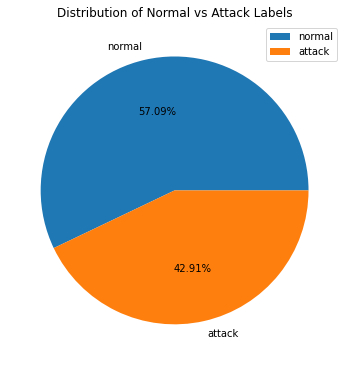

In [ ]:
# Plot the binary classification distribution
def plot_bin_label_dist(label):
  plt.figure(figsize = (6,8))
  plt.pie(label.value_counts(), labels = label.unique(), autopct='%0.2f%%')
  plt.title("Distribution of Normal vs Attack Labels")
  plt.legend()
  plt.savefig('{}/binary_labels.png'.format(PLOTS_DIR))
  plt.show()
plot_bin_label_dist(binary_data['label'])

## 2.   Multi-Class Classification

In [ ]:
# We then perform multi-class classification, where we bin the sample set into all possible unique values 
# of the label attribute, i.e, normal, DoS, Probe, R2L and U2R
# Create a clone of original dataset with multi labels
multi_data = train_data.copy()
# Encoding labels: 0 => DoS, 1 => Probe, 2 => R2L, 3 => normal
multi_le = preprocessing.LabelEncoder()
multi_data['encoded_label'] = pd.DataFrame(multi_data['label']).apply(multi_le.fit_transform)
test_data['encoded_label'] = multi_le.transform(test_data['label'])

In [ ]:
multi_data.groupby('label').encoded_label.mean()

label
DoS       0
Probe     1
R2L       2
normal    3
Name: encoded_label, dtype: int64

In [ ]:
test_data.groupby('label').encoded_label.mean()

label
DoS       0
Probe     1
R2L       2
normal    3
Name: encoded_label, dtype: int64

In [ ]:
multi_data.encoded_label.value_counts()

3    66701
0    37855
1    11290
2      993
Name: encoded_label, dtype: int64

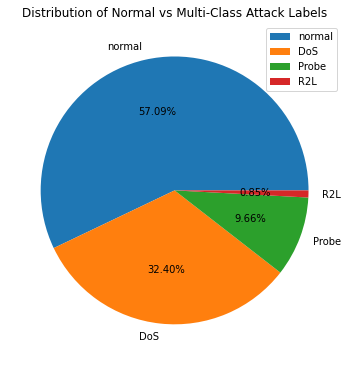

In [ ]:
# Plot the multi-class classification distribution
def plot_multi_label_dist(label):
  plt.figure(figsize = (6,8))
  plt.pie(label.value_counts(), labels = label.value_counts().index.to_list(), autopct='%0.2f%%')
  plt.title("Distribution of Normal vs Multi-Class Attack Labels")
  plt.legend()
  plt.savefig('{}/multi_labels.png'.format(PLOTS_DIR))
  plt.show()
plot_multi_label_dist(multi_data['label'])

# **Feature Selection**

---



## 1. Binary Features

In [ ]:
# Create dataframe with only numeric attributes of dataset and encoded binary labels
X_train = binary_data[my_cols]
Y_train = binary_data['encoded_label']

X_test = binary_test_data[my_cols]
Y_test = binary_test_data['encoded_label']
Y_test

0        0
1        0
2        1
3        0
4        0
        ..
22538    0
22539    1
22540    1
22541    0
22542    1
Name: encoded_label, Length: 20654, dtype: int64

In [ ]:
# Transform train and test sets into the format required by the deep learning models
transformed_train = preprocessor.fit_transform(X_train)
transformed_train = transformed_train.astype('float32')
transformed_train.shape

(116839, 58)

In [ ]:
transformed_test = preprocessor.transform(X_test)
transformed_test = transformed_test.astype('float32')
transformed_test.shape

(20654, 58)

In [ ]:
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = onehot.fit_transform(binary_data[['label']])
y_test = onehot.transform(test_data[['label']])

In [ ]:
# Compute correlation matrix and keep only feature attributes with correlation greater than 0.5 
# with the encoded label attribute
bin_corr_matrix = num_binary_data.corr()
bin_corr_y = abs(bin_corr_matrix['encoded_label'])
bin_features = bin_corr_y.loc[bin_corr_y >= 0.5].drop('encoded_label')
bin_feature_list = bin_features.index.to_list()
bin_feature_list

NameError: ignored

## 2. Multi-Class Features

In [ ]:
# Create dataframe with only numeric attributes of dataset and encoded binary labels
X_train = multi_data[my_cols]
Y_train = multi_data['encoded_label']

X_test = test_data[my_cols]
Y_test = test_data['encoded_label']
Y_test

0        0
1        0
2        3
3        1
4        1
        ..
22538    0
22539    3
22540    3
22541    0
22542    3
Name: encoded_label, Length: 20654, dtype: int64

In [ ]:
# Transform train and test sets into the format required by the deep learning models
transformed_train = preprocessor.fit_transform(X_train)
transformed_train = transformed_train.astype('float32')
transformed_train.shape

(116839, 58)

In [ ]:
transformed_test = preprocessor.transform(X_test)
transformed_test = transformed_test.astype('float32')
transformed_test.shape

(20654, 58)

In [ ]:
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = onehot.fit_transform(multi_data[['label']])
y_test = onehot.transform(test_data[['label']])

In [ ]:
# Compute correlation matrix and keep only feature attributes with correlation greater than 0.5 
# with the encoded label attribute
bin_corr_matrix = num_binary_data.corr()
bin_corr_y = abs(bin_corr_matrix['encoded_label'])
bin_features = bin_corr_y.loc[bin_corr_y >= 0.5].drop('encoded_label')
bin_feature_list = bin_features.index.to_list()
bin_feature_list

NameError: ignored

# **Machine Learning Models**

---







#  Binary Classifiers







## Logistic Regression (Baseline Model)

In [ ]:
model = LogisticRegression()

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

In [ ]:
preds = lin_clf.predict(X_test)
accuracy_score(Y_test, preds)

0.7753945966882928

## 1. Linear Support Vector Machine Classifier (LSVM)

In [ ]:
lsvm = svm.SVC(kernel='linear',gamma='auto')

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', lsvm)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['same_srv_rate',
                                                   'dst_host_srv_serror_rate',
                                                   'dst_host_serror_rate',
                                                   'srv_serror_rate',
                                                   'serror_rate',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_srv_count',
                                                   'count', 'srv_count',
                                                   'src_bytes', 'dst_bytes']),
                                                 ('cat',
                                   

In [ ]:
y_pred = lin_clf.predict(X_test)
accuracy_score(y_pred, Y_test)

0.7874503728091411

In [ ]:
print(classification_report(Y_test, y_pred, target_names=binary_le.classes_))

              precision    recall  f1-score   support

      attack       0.89      0.69      0.77     10979
      normal       0.72      0.90      0.80      9675

    accuracy                           0.79     20654
   macro avg       0.80      0.79      0.79     20654
weighted avg       0.81      0.79      0.79     20654



In [ ]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(Y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(Y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(Y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(Y_test, y_pred)*100)

Mean Absolute Error -  0.2125496271908589
Mean Squared Error -  0.2125496271908589
Root Mean Squared Error -  0.46103104796841926
R2 Score -  20.411380617872087
Accuracy -  78.7450372809141


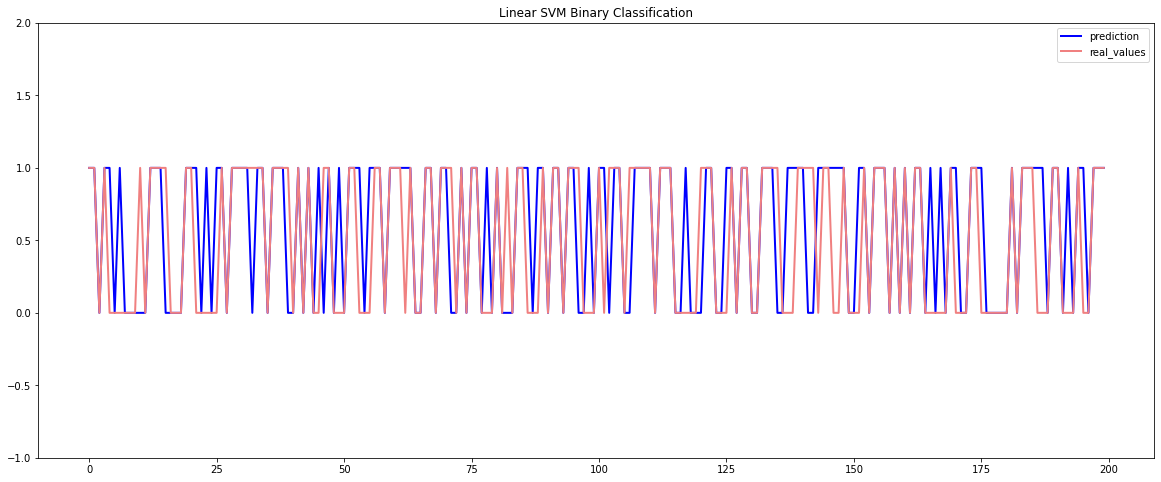

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_pred[300:500], label="prediction", linewidth=2.0, color='blue')
plt.plot(Y_test[300:500].values, label="real_values", linewidth=2.0, color='lightcoral')
plt.legend(loc="best")
plt.ylim((-1,2))
plt.title("Linear SVM Binary Classification")
plt.savefig('{}/lsvm_pred_bin.png'.format(PLOTS_DIR))
plt.show()

## 2. Quadratic Support Vector Machine (QSVM)

In [ ]:
qsvm = svm.SVC(kernel = 'poly', gamma='auto')

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', qsvm)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['same_srv_rate',
                                                   'dst_host_srv_serror_rate',
                                                   'dst_host_serror_rate',
                                                   'srv_serror_rate',
                                                   'serror_rate',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_srv_count',
                                                   'count', 'srv_count',
                                                   'src_bytes', 'dst_bytes']),
                                                 ('cat',
                                   

In [ ]:
y_pred = lin_clf.predict(X_test)
accuracy_score(y_pred, Y_test)

0.7940350537426164

In [ ]:
print(classification_report(Y_test, y_pred, target_names=binary_le.classes_))

              precision    recall  f1-score   support

      attack       0.95      0.64      0.77     10979
      normal       0.70      0.97      0.81      9675

    accuracy                           0.79     20654
   macro avg       0.83      0.80      0.79     20654
weighted avg       0.84      0.79      0.79     20654



In [ ]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(Y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(Y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(Y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(Y_test, y_pred)*100)

Mean Absolute Error -  0.20596494625738357
Mean Squared Error -  0.20596494625738357
Root Mean Squared Error -  0.45383361076212014
R2 Score -  29.363488153211435
Accuracy -  79.40350537426164


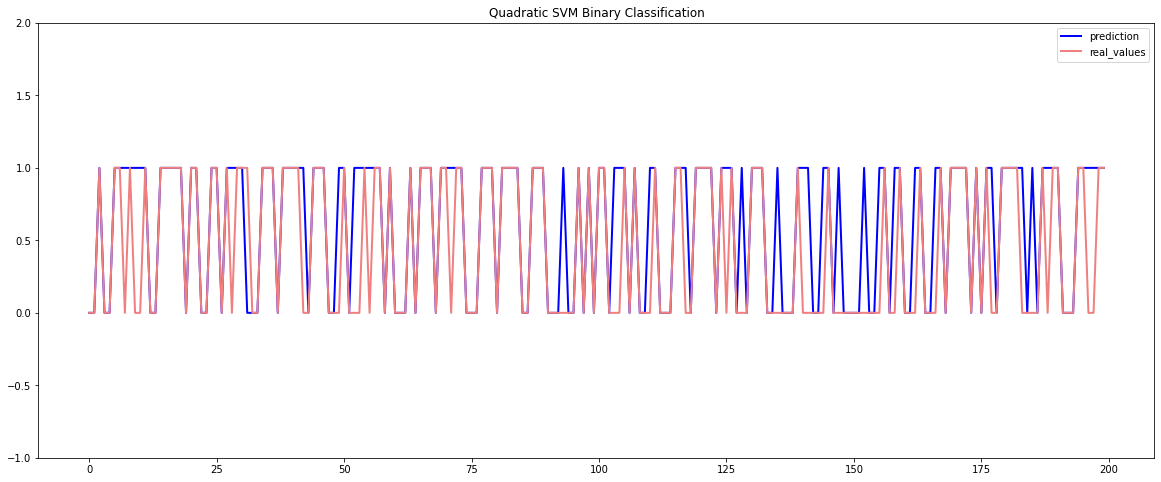

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_pred[0:200], label="prediction", linewidth=2.0, color='blue')
plt.plot(Y_test[0:200].values, label="real_values", linewidth=2.0, color='lightcoral')
plt.legend(loc="best")
plt.ylim((-1,2))
plt.title("Quadratic SVM Binary Classification")
plt.savefig('{}/qsvm_pred_bin.png'.format(PLOTS_DIR))
plt.show()

## 3. K-Nearest Neighbor (KNN)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', knn)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['same_srv_rate',
                                                   'dst_host_srv_serror_rate',
                                                   'dst_host_serror_rate',
                                                   'srv_serror_rate',
                                                   'serror_rate',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_srv_count',
                                                   'count', 'srv_count',
                                                   'src_bytes', 'dst_bytes']),
                                                 ('cat',
                                   

In [ ]:
y_pred = lin_clf.predict(X_test)
accuracy_score(y_pred, Y_test)

0.802653239082018

In [ ]:
print(classification_report(Y_test, y_pred, target_names=binary_le.classes_))

              precision    recall  f1-score   support

      attack       0.91      0.70      0.79     10979
      normal       0.73      0.92      0.81      9675

    accuracy                           0.80     20654
   macro avg       0.82      0.81      0.80     20654
weighted avg       0.83      0.80      0.80     20654



In [ ]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(Y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(Y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(Y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(Y_test, y_pred)*100)

Mean Absolute Error -  0.19734676091798198
Mean Squared Error -  0.19734676091798198
Root Mean Squared Error -  0.444237279973194
R2 Score -  26.953731024674067
Accuracy -  80.26532390820181


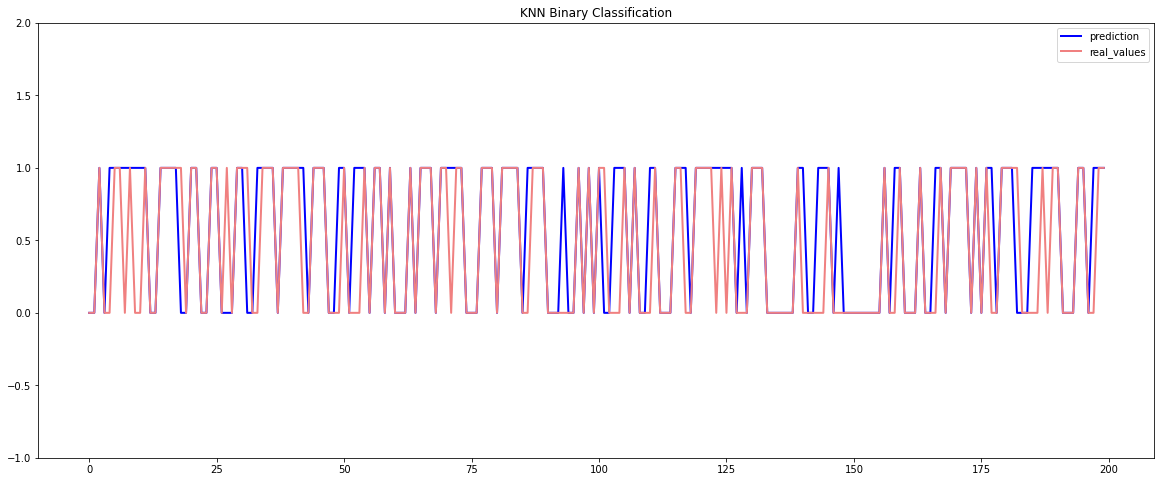

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_pred[0:200], label="prediction", linewidth=2.0, color='blue')
plt.plot(Y_test[0:200].values, label="real_values", linewidth=2.0, color='lightcoral')
plt.legend(loc="best")
plt.ylim((-1,2))
plt.title("KNN Binary Classification")
plt.savefig('{}/knn_pred_bin.png'.format(PLOTS_DIR))
plt.show()

## 4. Linear Discriminant Analysis (LDA)

In [ ]:
lda = LinearDiscriminantAnalysis()

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', lda)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['same_srv_rate',
                                                   'dst_host_srv_serror_rate',
                                                   'dst_host_serror_rate',
                                                   'srv_serror_rate',
                                                   'serror_rate',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_srv_count',
                                                   'count', 'srv_count',
                                                   'src_bytes', 'dst_bytes']),
                                                 ('cat',
                                   

In [ ]:
y_pred = lin_clf.predict(X_test)
accuracy_score(y_pred, Y_test)

0.7767502662922436

In [ ]:
print(classification_report(Y_test, y_pred, target_names=binary_le.classes_))

              precision    recall  f1-score   support

      attack       0.91      0.65      0.75     10979
      normal       0.70      0.93      0.80      9675

    accuracy                           0.78     20654
   macro avg       0.80      0.79      0.77     20654
weighted avg       0.81      0.78      0.77     20654



In [ ]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(Y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(Y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(Y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(Y_test, y_pred)*100)

Mean Absolute Error -  0.22324973370775636
Mean Squared Error -  0.22324973370775636
Root Mean Squared Error -  0.47249310440233555
R2 Score -  19.856815677945626
Accuracy -  77.67502662922436


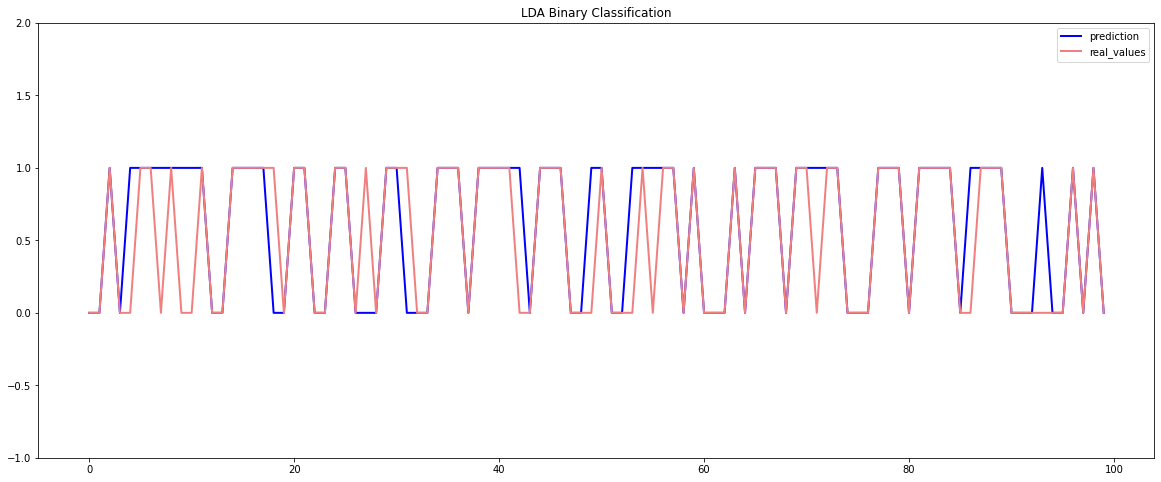

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_pred[0:100], label="prediction", linewidth=2.0, color='blue')
plt.plot(Y_test[0:100].values, label="real_values", linewidth=2.0, color='lightcoral')
plt.legend(loc="best")
plt.ylim((-1,2))
plt.title("LDA Binary Classification")
plt.savefig('{}/lda_pred_bin.png'.format(PLOTS_DIR))
plt.show()

## 5. Quadratic Discriminant Analysis (QDA)

In [ ]:
qda = QuadraticDiscriminantAnalysis()

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', qda)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['same_srv_rate',
                                                   'dst_host_srv_serror_rate',
                                                   'dst_host_serror_rate',
                                                   'srv_serror_rate',
                                                   'serror_rate',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_srv_count',
                                                   'count', 'srv_count',
                                                   'src_bytes', 'dst_bytes']),
                                                 ('cat',
                                   

In [ ]:
y_pred = lin_clf.predict(X_test)
accuracy_score(y_pred, Y_test)

0.6150866660211097

In [ ]:
print(classification_report(Y_test, y_pred, target_names=binary_le.classes_))

              precision    recall  f1-score   support

      attack       0.99      0.28      0.44     10979
      normal       0.55      1.00      0.71      9675

    accuracy                           0.62     20654
   macro avg       0.77      0.64      0.57     20654
weighted avg       0.78      0.62      0.56     20654



In [ ]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(Y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(Y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(Y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(Y_test, y_pred)*100)

Mean Absolute Error -  0.38491333397889027
Mean Squared Error -  0.38491333397889027
Root Mean Squared Error -  0.6204138408988715
R2 Score -  3.875780707025156
Accuracy -  61.50866660211097


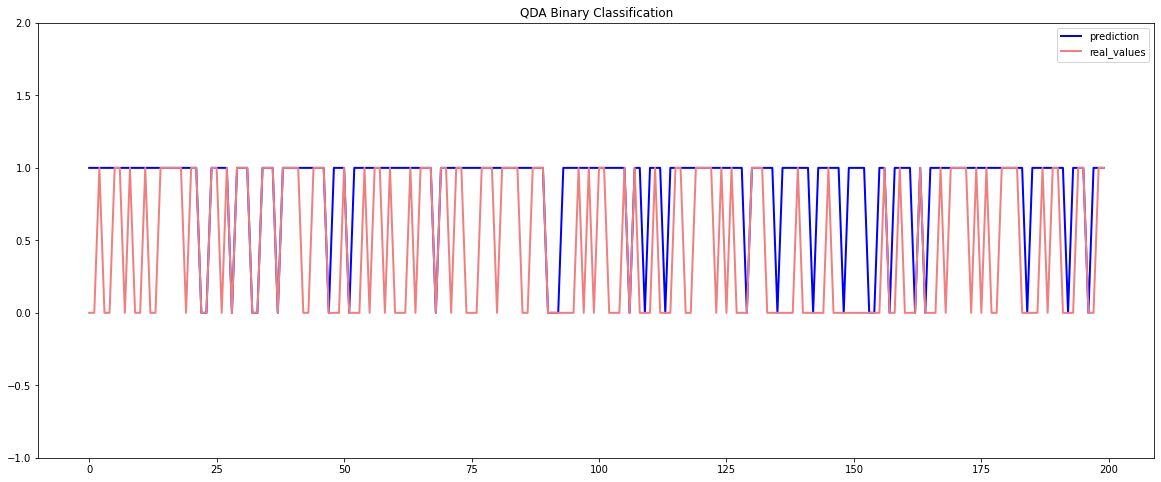

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_pred[0:200], label="prediction", linewidth=2.0, color='blue')
plt.plot(Y_test[0:200].values, label="real_values", linewidth=2.0, color='lightcoral')
plt.legend(loc="best")
plt.ylim((-1,2))
plt.title("QDA Binary Classification")
plt.savefig('{}/qda_pred_bin.png'.format(PLOTS_DIR))
plt.show()

## 6. Multi Layer Perceptron (MLP)

In [ ]:
mlp = Sequential() # creating model

# adding input layer and first layer with 50 neurons
mlp.add(Dense(units=50, input_dim=tranformed_train.shape[1], activation='relu'))
# output layer with sigmoid activation
mlp.add(Dense(units=2,activation='sigmoid'))

In [ ]:
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 50)                2950      
                                                                 
 dense_13 (Dense)            (None, 2)                 102       
                                                                 
Total params: 3,052
Trainable params: 3,052
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = mlp.fit(tranformed_train, y_train, epochs=50, batch_size=5000, validation_split=0.2)

Epoch 1/100
19/19 [==============================] - 1s 19ms/step - loss: 0.5628 - accuracy: 0.8219 - val_loss: 0.4502 - val_accuracy: 0.8911
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.3815 - accuracy: 0.9073 - val_loss: 0.3153 - val_accuracy: 0.9325
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.2723 - accuracy: 0.9443 - val_loss: 0.2310 - val_accuracy: 0.9561
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.2050 - accuracy: 0.9580 - val_loss: 0.1800 - val_accuracy: 0.9606
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1656 - accuracy: 0.9627 - val_loss: 0.1513 - val_accuracy: 0.9641
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1437 - accuracy: 0.9661 - val_loss: 0.1351 - val_accuracy: 0.9676
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1310 - accuracy: 0.9677 - val_loss: 0.1254 - val_accuracy: 0.9681
Epoch 8/100


In [ ]:
preds = mlp.predict(transformed_test).argmax(axis=1)
print(classification_report(preds, Y_test, target_names = binary_le.classes_))

              precision    recall  f1-score   support

      attack       0.67      0.91      0.78      8106
      normal       0.93      0.71      0.81     12548

    accuracy                           0.79     20654
   macro avg       0.80      0.81      0.79     20654
weighted avg       0.83      0.79      0.79     20654



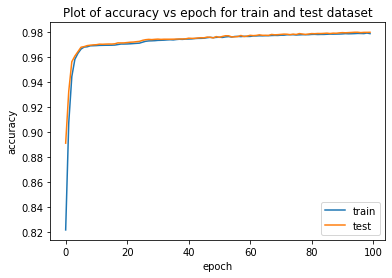

In [ ]:
# Plot of accuracy vs epoch of train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('{}/mlp_binary_accuracy.png'.format(PLOTS_DIR))
plt.show()

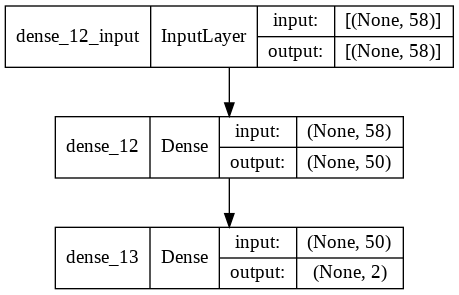

In [ ]:
plot_model(mlp, to_file='{}/mlp_binary.png'.format(PLOTS_DIR), show_shapes=True,)

## 7. Long Short-Term Memory (LSTM)

In [ ]:
X_train_LSTM = np.reshape(tranformed_train, (tranformed_train.shape[0], 1, tranformed_train.shape[1]))
X_train_LSTM.shape

(116839, 1, 58)

In [ ]:
lstm = Sequential()
# input layer and LSTM layer with 50 neurons
lstm.add(LSTM(50, input_dim = X_train_LSTM.shape[2]))

# outpute layer with sigmoid activation
lstm.add(Dense(2,activation='sigmoid'))

# defining loss function, optimizer, metrics and then compiling model
lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                21800     
                                                                 
 dense_19 (Dense)            (None, 2)                 102       
                                                                 
Total params: 21,902
Trainable params: 21,902
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm.fit(X_train_LSTM, y_train, epochs=50, batch_size=5000, validation_split=0.2)

Epoch 1/50
19/19 [==============================] - 5s 42ms/step - loss: 0.6481 - accuracy: 0.8280 - val_loss: 0.6112 - val_accuracy: 0.8368
Epoch 2/50
19/19 [==============================] - 0s 10ms/step - loss: 0.5745 - accuracy: 0.8534 - val_loss: 0.5303 - val_accuracy: 0.8666
Epoch 3/50
19/19 [==============================] - 0s 10ms/step - loss: 0.4862 - accuracy: 0.8783 - val_loss: 0.4357 - val_accuracy: 0.8909
Epoch 4/50
19/19 [==============================] - 0s 10ms/step - loss: 0.3915 - accuracy: 0.8932 - val_loss: 0.3450 - val_accuracy: 0.8957
Epoch 5/50
19/19 [==============================] - 0s 12ms/step - loss: 0.3102 - accuracy: 0.9003 - val_loss: 0.2753 - val_accuracy: 0.9060
Epoch 6/50
19/19 [==============================] - 0s 10ms/step - loss: 0.2511 - accuracy: 0.9188 - val_loss: 0.2267 - val_accuracy: 0.9377
Epoch 7/50
19/19 [==============================] - 0s 10ms/step - loss: 0.2100 - accuracy: 0.9449 - val_loss: 0.1928 - val_accuracy: 0.9520
Epoch 8/50
19

In [ ]:
X_test_LSTM = np.reshape(transformed_test, (transformed_test.shape[0], 1, transformed_test.shape[1]))
X_test_LSTM.shape

(20654, 1, 58)

In [ ]:
preds = lstm.predict(X_test_LSTM).argmax(axis=1)
print(classification_report(preds, Y_test, target_names = binary_le.classes_))

              precision    recall  f1-score   support

      attack       0.65      0.91      0.76      7822
      normal       0.93      0.70      0.80     12832

    accuracy                           0.78     20654
   macro avg       0.79      0.80      0.78     20654
weighted avg       0.82      0.78      0.78     20654



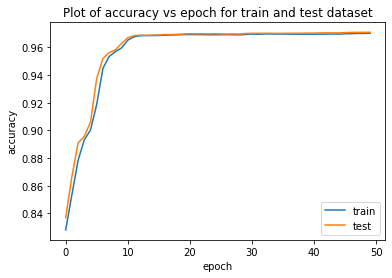

In [ ]:
# Plot of accuracy vs epoch of train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('{}/lstm_binary_accuracy.png'.format(PLOTS_DIR))
plt.show()

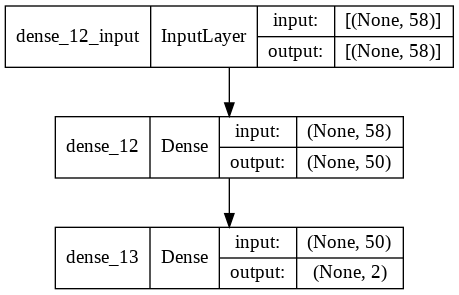

In [ ]:
plot_model(lstm, to_file='{}/lstm_binary.png'.format(PLOTS_DIR), show_shapes=True,)

## 8. Auto Encoder (AE)

In [ ]:
input_dim = transformed_train.shape[1]
encoding_dim = 50

#input layer
input_layer = Input(shape=(input_dim, ))
#encoding layer with 50 neurons
encoder = Dense(encoding_dim, activation="relu")(input_layer)           
#decoding and output layer
output_layer = Dense(input_dim, activation='softmax')(encoder)

In [ ]:
# creating model with input, encoding, decoding, output layers
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# defining loss function, optimizer, metrics and then compiling model
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 58)]              0         
                                                                 
 dense_22 (Dense)            (None, 50)                2950      
                                                                 
 dense_23 (Dense)            (None, 58)                2958      
                                                                 
Total params: 5,908
Trainable params: 5,908
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(transformed_train, transformed_train, epochs=100, batch_size=500, validation_data=(transformed_test, transformed_test)).history

In [ ]:
#test_results = autoencoder.evaluate(transformed_test, transformed_test, verbose=1)
#print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

In [ ]:
# calculating reconstruction error 
predictions = autoencoder.predict(transformed_test)
mse = np.mean(np.power(transformed_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': Y_test})
error_df = error_df.reset_index()
error_df

,index,reconstruction_error,true_class
0,0,0.029413,0
1,1,0.027086,0
2,2,0.048620,1
3,3,0.059965,0
4,4,0.046983,0
...,...,...,...
20649,22538,0.073648,0
20650,22539,0.054426,1
20651,22540,0.071851,1
20652,22541,0.071847,0


In [ ]:
i_dim = predictions.shape[1]

#input layer
i_layer = Input(shape=(i_dim, ))
#hidden layer with 50 neurons
fvector = Dense(50, activation="sigmoid")(i_layer)                    
#doutput layer
o_layer = Dense(2, activation='sigmoid')(fvector)

In [ ]:
# creating model with input, encoding, decoding, output layers
ae_classifier = Model(inputs=i_layer, outputs=o_layer)

# defining loss function, optimizer, metrics and then compiling model
ae_classifier.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
his = ae_classifier.fit(predictions, y_test, epochs=100, batch_size=500).history

Epoch 1/100
42/42 [==============================] - 1s 4ms/step - loss: 0.7027 - accuracy: 0.5316
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.5316
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 0.6643 - accuracy: 0.5389
Epoch 4/100
42/42 [==============================] - 0s 5ms/step - loss: 0.6514 - accuracy: 0.5389
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.7849
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.8090
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.5977 - accuracy: 0.8028
Epoch 8/100
42/42 [==============================] - 0s 4ms/step - loss: 0.5756 - accuracy: 0.7979
Epoch 9/100
42/42 [==============================] - 0s 5ms/step - loss: 0.5534 - accuracy: 0.7905
Epoch 10/100
42/42 [==============================] - 0s 4ms/step - loss: 0.5328 - accuracy: 0.7888
Epoch 11/

In [ ]:
preds = ae_classifier.predict(transformed_test).argmax(axis=1)
print(classification_report(preds, Y_test))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77      8094
           1       0.93      0.71      0.81     12560

    accuracy                           0.79     20654
   macro avg       0.80      0.81      0.79     20654
weighted avg       0.83      0.79      0.79     20654



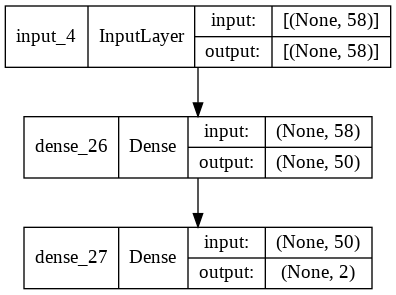

In [ ]:
plot_model(ae_classifier, to_file='{}/ae_classifier_binary.png'.format(PLOTS_DIR), show_shapes=True,)

# Multiclass Classifiers


## Logistic Regression (Baseline Model)

In [ ]:
model = LogisticRegression()

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['same_srv_rate',
                                                   'dst_host_srv_serror_rate',
                                                   'dst_host_serror_rate',
                                                   'srv_serror_rate',
                                                   'serror_rate',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_srv_count',
                                                   'count', 'srv_count',
                                                   'src_bytes', 'dst_bytes']),
                                                 ('cat',
                                   

In [ ]:
preds = lin_clf.predict(X_test)
accuracy_score(Y_test, preds)

0.7665343274910429

## 1. Linear Support Vector Machine Classifier (LSVM)

In [ ]:
lsvm = svm.SVC(kernel='linear',gamma='auto')

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', lsvm)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['same_srv_rate',
                                                   'dst_host_srv_serror_rate',
                                                   'dst_host_serror_rate',
                                                   'srv_serror_rate',
                                                   'serror_rate',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_srv_count',
                                                   'count', 'srv_count',
                                                   'src_bytes', 'dst_bytes']),
                                                 ('cat',
                                   

In [ ]:
y_pred = lin_clf.predict(X_test)
accuracy_score(y_pred, Y_test)

0.764888157257674

In [ ]:
print(classification_report(Y_test, y_pred, target_names=multi_le.classes_))

              precision    recall  f1-score   support

         DoS       0.85      0.80      0.82      6855
       Probe       0.83      0.59      0.69      2001
         R2L       0.93      0.11      0.20      2123
      normal       0.71      0.92      0.80      9675

    accuracy                           0.76     20654
   macro avg       0.83      0.61      0.63     20654
weighted avg       0.79      0.76      0.74     20654



In [ ]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(Y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(Y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(Y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(Y_test, y_pred)*100)

Mean Absolute Error -  0.4527452309480004
Mean Squared Error -  1.0763532487653724
Root Mean Squared Error -  1.0374744569218908
R2 Score -  42.85640503735058
Accuracy -  76.4888157257674


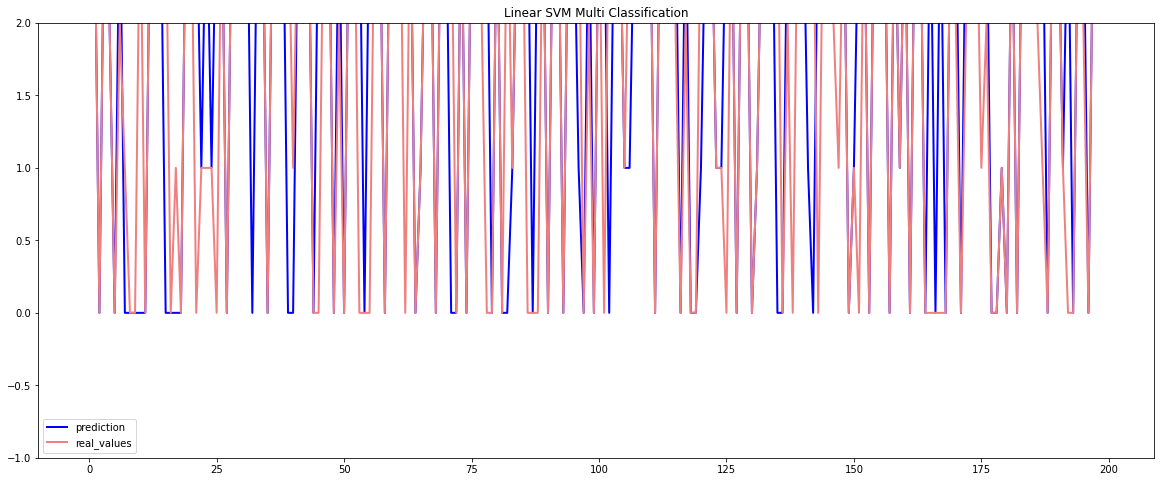

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_pred[300:500], label="prediction", linewidth=2.0, color='blue')
plt.plot(Y_test[300:500].values, label="real_values", linewidth=2.0, color='lightcoral')
plt.legend(loc="best")
plt.ylim((-1,2))
plt.title("Linear SVM Multi Classification")
plt.savefig('{}/lsvm_pred_multi.png'.format(PLOTS_DIR))
plt.show()

## 2. Quadratic Support Vector Machine (QSVM)

In [ ]:
qsvm = svm.SVC(kernel = 'poly', gamma='auto')

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', qsvm)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['same_srv_rate',
                                                   'dst_host_srv_serror_rate',
                                                   'dst_host_serror_rate',
                                                   'srv_serror_rate',
                                                   'serror_rate',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_srv_count',
                                                   'count', 'srv_count',
                                                   'src_bytes', 'dst_bytes']),
                                                 ('cat',
                                   

In [ ]:
y_pred = lin_clf.predict(X_test)
accuracy_score(y_pred, Y_test)

0.6069042316258352

In [ ]:
print(classification_report(Y_test, y_pred, target_names=multi_le.classes_))

              precision    recall  f1-score   support

         DoS       0.87      0.38      0.53      6855
       Probe       0.94      0.15      0.26      2001
         R2L       0.00      0.00      0.00      2123
      normal       0.55      0.99      0.71      9675

    accuracy                           0.61     20654
   macro avg       0.59      0.38      0.38     20654
weighted avg       0.64      0.61      0.54     20654



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(Y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(Y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(Y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(Y_test, y_pred)*100)

Mean Absolute Error -  0.8743584777767018
Mean Squared Error -  2.251234627675027
Root Mean Squared Error -  1.500411486118067
R2 Score -  13.280327109220947
Accuracy -  60.69042316258352


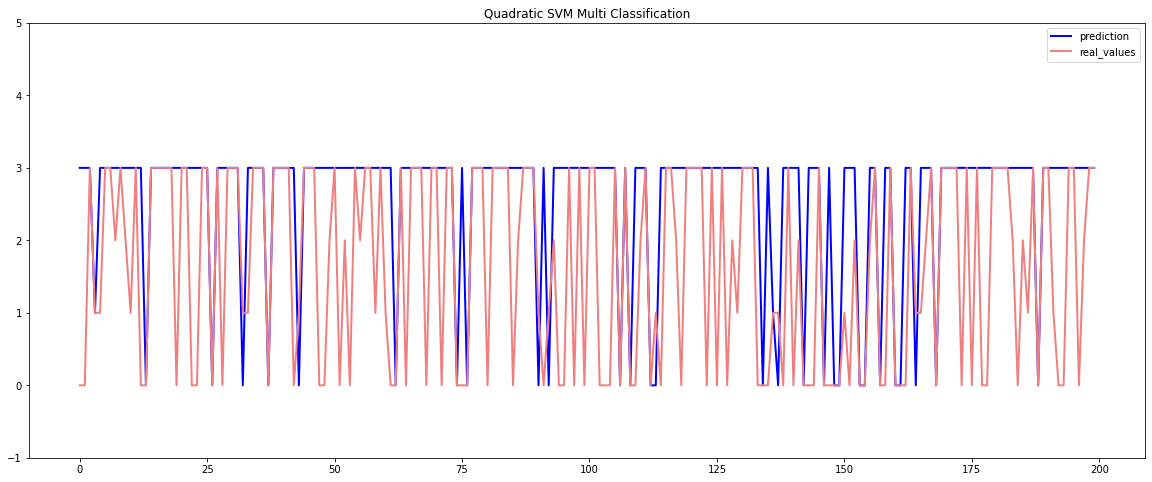

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_pred[0:200], label="prediction", linewidth=2.0, color='blue')
plt.plot(Y_test[0:200].values, label="real_values", linewidth=2.0, color='lightcoral')
plt.legend(loc="best")
plt.ylim((-1,5))
plt.title("Quadratic SVM Multi Classification")
plt.savefig('{}/qsvm_pred_multi.png'.format(PLOTS_DIR))
plt.show()

## 3. K-Nearest Neighbor (KNN)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', knn)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['same_srv_rate',
                                                   'dst_host_srv_serror_rate',
                                                   'dst_host_serror_rate',
                                                   'srv_serror_rate',
                                                   'serror_rate',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_srv_count',
                                                   'count', 'srv_count',
                                                   'src_bytes', 'dst_bytes']),
                                                 ('cat',
                                   

In [ ]:
y_pred = lin_clf.predict(X_test)
accuracy_score(y_pred, Y_test)

0.802653239082018

In [ ]:
print(classification_report(Y_test, y_pred, target_names=binary_le.classes_))

              precision    recall  f1-score   support

      attack       0.91      0.70      0.79     10979
      normal       0.73      0.92      0.81      9675

    accuracy                           0.80     20654
   macro avg       0.82      0.81      0.80     20654
weighted avg       0.83      0.80      0.80     20654



In [ ]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(Y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(Y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(Y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(Y_test, y_pred)*100)

Mean Absolute Error -  0.19734676091798198
Mean Squared Error -  0.19734676091798198
Root Mean Squared Error -  0.444237279973194
R2 Score -  26.953731024674067
Accuracy -  80.26532390820181


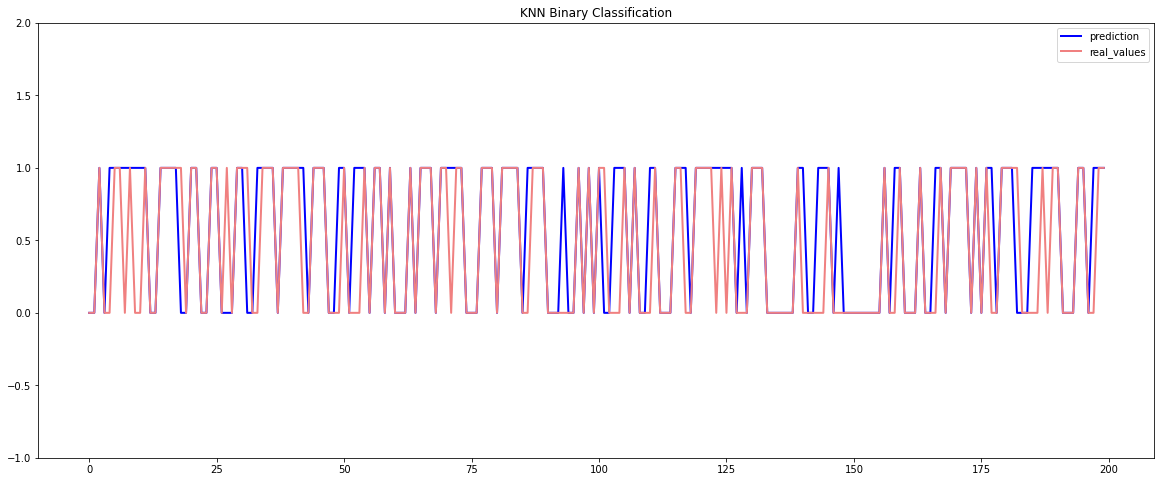

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_pred[0:200], label="prediction", linewidth=2.0, color='blue')
plt.plot(Y_test[0:200].values, label="real_values", linewidth=2.0, color='lightcoral')
plt.legend(loc="best")
plt.ylim((-1,2))
plt.title("KNN Binary Classification")
plt.savefig('{}/knn_pred_bin.png'.format(PLOTS_DIR))
plt.show()

## 4. Linear Discriminant Analysis (LDA)

In [ ]:
lda = LinearDiscriminantAnalysis()

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', lda)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['same_srv_rate',
                                                   'dst_host_srv_serror_rate',
                                                   'dst_host_serror_rate',
                                                   'srv_serror_rate',
                                                   'serror_rate',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_srv_count',
                                                   'count', 'srv_count',
                                                   'src_bytes', 'dst_bytes']),
                                                 ('cat',
                                   

In [ ]:
y_pred = lin_clf.predict(X_test)
accuracy_score(y_pred, Y_test)

0.7767502662922436

In [ ]:
print(classification_report(Y_test, y_pred, target_names=binary_le.classes_))

              precision    recall  f1-score   support

      attack       0.91      0.65      0.75     10979
      normal       0.70      0.93      0.80      9675

    accuracy                           0.78     20654
   macro avg       0.80      0.79      0.77     20654
weighted avg       0.81      0.78      0.77     20654



In [ ]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(Y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(Y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(Y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(Y_test, y_pred)*100)

Mean Absolute Error -  0.22324973370775636
Mean Squared Error -  0.22324973370775636
Root Mean Squared Error -  0.47249310440233555
R2 Score -  19.856815677945626
Accuracy -  77.67502662922436


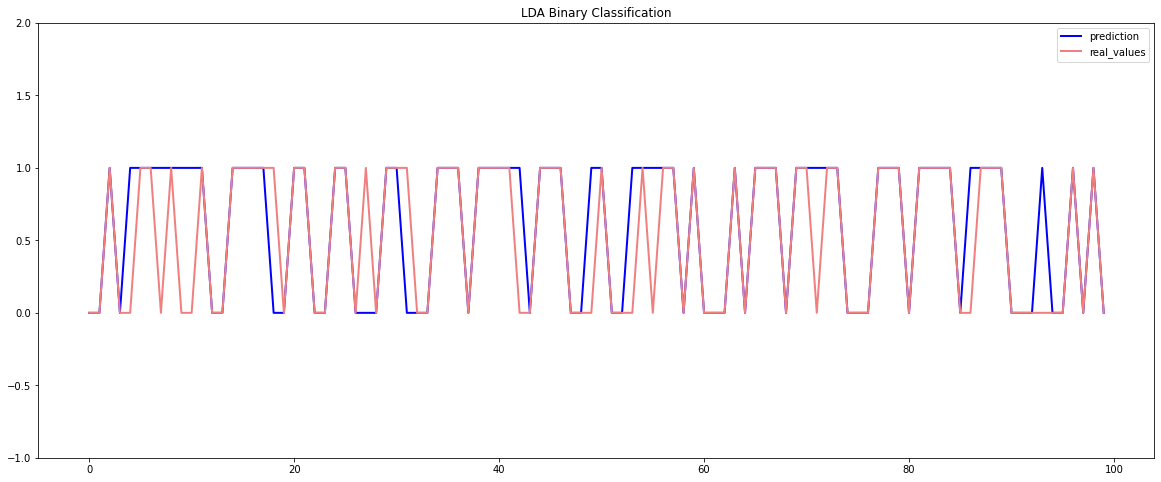

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_pred[0:100], label="prediction", linewidth=2.0, color='blue')
plt.plot(Y_test[0:100].values, label="real_values", linewidth=2.0, color='lightcoral')
plt.legend(loc="best")
plt.ylim((-1,2))
plt.title("LDA Binary Classification")
plt.savefig('{}/lda_pred_bin.png'.format(PLOTS_DIR))
plt.show()

## 5. Quadratic Discriminant Analysis (QDA)

In [ ]:
qda = QuadraticDiscriminantAnalysis()

In [ ]:
lin_clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', qda)
                     ])

In [ ]:
lin_clf.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['same_srv_rate',
                                                   'dst_host_srv_serror_rate',
                                                   'dst_host_serror_rate',
                                                   'srv_serror_rate',
                                                   'serror_rate',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_srv_count',
                                                   'count', 'srv_count',
                                                   'src_bytes', 'dst_bytes']),
                                                 ('cat',
                                   

In [ ]:
y_pred = lin_clf.predict(X_test)
accuracy_score(y_pred, Y_test)

0.6150866660211097

In [ ]:
print(classification_report(Y_test, y_pred, target_names=binary_le.classes_))

              precision    recall  f1-score   support

      attack       0.99      0.28      0.44     10979
      normal       0.55      1.00      0.71      9675

    accuracy                           0.62     20654
   macro avg       0.77      0.64      0.57     20654
weighted avg       0.78      0.62      0.56     20654



In [ ]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(Y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(Y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(Y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(Y_test, y_pred)*100)

Mean Absolute Error -  0.38491333397889027
Mean Squared Error -  0.38491333397889027
Root Mean Squared Error -  0.6204138408988715
R2 Score -  3.875780707025156
Accuracy -  61.50866660211097


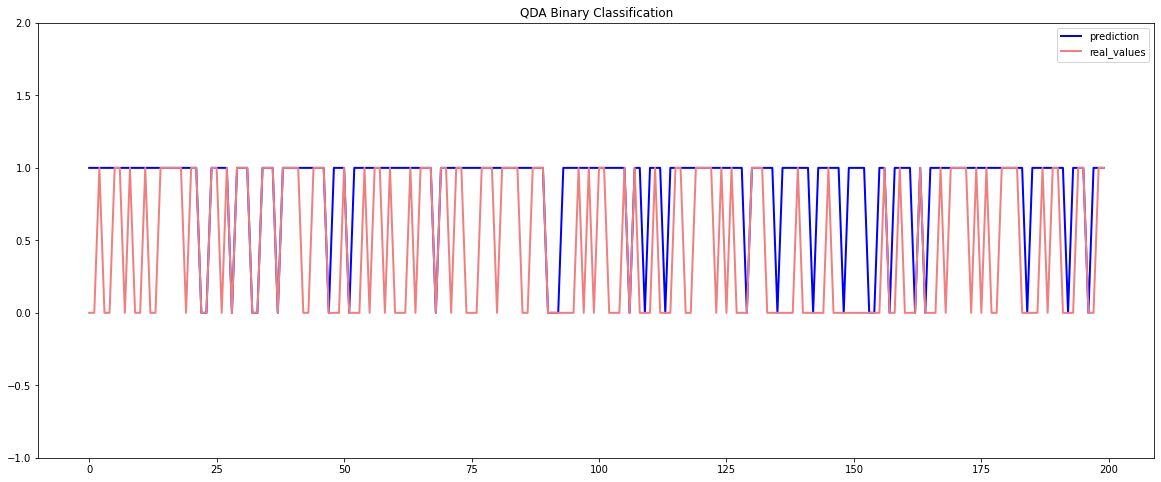

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_pred[0:200], label="prediction", linewidth=2.0, color='blue')
plt.plot(Y_test[0:200].values, label="real_values", linewidth=2.0, color='lightcoral')
plt.legend(loc="best")
plt.ylim((-1,2))
plt.title("QDA Binary Classification")
plt.savefig('{}/qda_pred_bin.png'.format(PLOTS_DIR))
plt.show()

## 6. Multi Layer Perceptron (MLP)

In [ ]:
mlp = Sequential() # creating model

# adding input layer and first layer with 50 neurons
mlp.add(Dense(units=50, input_dim=tranformed_train.shape[1], activation='relu'))
# output layer with sigmoid activation
mlp.add(Dense(units=2,activation='sigmoid'))

In [ ]:
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 50)                2950      
                                                                 
 dense_13 (Dense)            (None, 2)                 102       
                                                                 
Total params: 3,052
Trainable params: 3,052
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = mlp.fit(tranformed_train, y_train, epochs=50, batch_size=5000, validation_split=0.2)

Epoch 1/100
19/19 [==============================] - 1s 19ms/step - loss: 0.5628 - accuracy: 0.8219 - val_loss: 0.4502 - val_accuracy: 0.8911
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.3815 - accuracy: 0.9073 - val_loss: 0.3153 - val_accuracy: 0.9325
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.2723 - accuracy: 0.9443 - val_loss: 0.2310 - val_accuracy: 0.9561
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.2050 - accuracy: 0.9580 - val_loss: 0.1800 - val_accuracy: 0.9606
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1656 - accuracy: 0.9627 - val_loss: 0.1513 - val_accuracy: 0.9641
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1437 - accuracy: 0.9661 - val_loss: 0.1351 - val_accuracy: 0.9676
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1310 - accuracy: 0.9677 - val_loss: 0.1254 - val_accuracy: 0.9681
Epoch 8/100


In [ ]:
preds = mlp.predict(transformed_test).argmax(axis=1)
print(classification_report(preds, Y_test, target_names = binary_le.classes_))

              precision    recall  f1-score   support

      attack       0.67      0.91      0.78      8106
      normal       0.93      0.71      0.81     12548

    accuracy                           0.79     20654
   macro avg       0.80      0.81      0.79     20654
weighted avg       0.83      0.79      0.79     20654



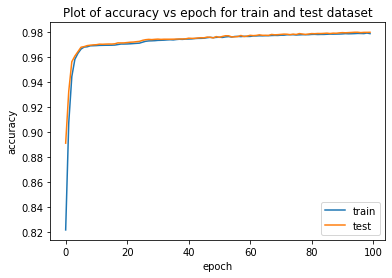

In [ ]:
# Plot of accuracy vs epoch of train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('{}/mlp_binary_accuracy.png'.format(PLOTS_DIR))
plt.show()

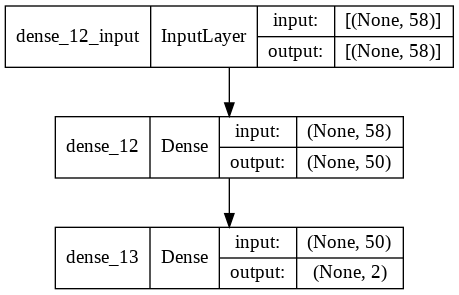

In [ ]:
plot_model(mlp, to_file='{}/mlp_binary.png'.format(PLOTS_DIR), show_shapes=True,)

## 7. Long Short-Term Memory (LSTM)

In [ ]:
X_train_LSTM = np.reshape(transformed_train, (transformed_train.shape[0], 1, transformed_train.shape[1]))
X_train_LSTM.shape

(116839, 1, 58)

In [ ]:
lstm = Sequential()
# input layer and LSTM layer with 50 neurons
lstm.add(LSTM(50, input_dim = X_train_LSTM.shape[2]))

# outpute layer with sigmoid activation
lstm.add(Dense(4,activation='sigmoid'))

# defining loss function, optimizer, metrics and then compiling model
lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                21800     
                                                                 
 dense_8 (Dense)             (None, 4)                 204       
                                                                 
Total params: 22,004
Trainable params: 22,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm.fit(X_train_LSTM, y_train, epochs=50, batch_size=5000, validation_split=0.2)

Epoch 1/50
19/19 [==============================] - 3s 42ms/step - loss: 0.6596 - accuracy: 0.6435 - val_loss: 0.6199 - val_accuracy: 0.8152
Epoch 2/50
19/19 [==============================] - 0s 10ms/step - loss: 0.5832 - accuracy: 0.8185 - val_loss: 0.5390 - val_accuracy: 0.8198
Epoch 3/50
19/19 [==============================] - 0s 10ms/step - loss: 0.4963 - accuracy: 0.8225 - val_loss: 0.4466 - val_accuracy: 0.8238
Epoch 4/50
19/19 [==============================] - 0s 10ms/step - loss: 0.4031 - accuracy: 0.8292 - val_loss: 0.3562 - val_accuracy: 0.8363
Epoch 5/50
19/19 [==============================] - 0s 10ms/step - loss: 0.3200 - accuracy: 0.8478 - val_loss: 0.2838 - val_accuracy: 0.8548
Epoch 6/50
19/19 [==============================] - 0s 10ms/step - loss: 0.2582 - accuracy: 0.8591 - val_loss: 0.2338 - val_accuracy: 0.8626
Epoch 7/50
19/19 [==============================] - 0s 9ms/step - loss: 0.2169 - accuracy: 0.8655 - val_loss: 0.2009 - val_accuracy: 0.8673
Epoch 8/50
19/

In [ ]:
X_test_LSTM = np.reshape(transformed_test, (transformed_test.shape[0], 1, transformed_test.shape[1]))
X_test_LSTM.shape

(20654, 1, 58)

In [ ]:
preds = lstm.predict(X_test_LSTM).argmax(axis=1)
print(classification_report(preds, Y_test, target_names = multi_le.classes_))

              precision    recall  f1-score   support

         DoS       0.71      0.83      0.77      5844
       Probe       0.56      0.82      0.67      1375
         R2L       0.00      0.00      0.00         1
      normal       0.93      0.67      0.78     13434

    accuracy                           0.73     20654
   macro avg       0.55      0.58      0.55     20654
weighted avg       0.84      0.73      0.77     20654



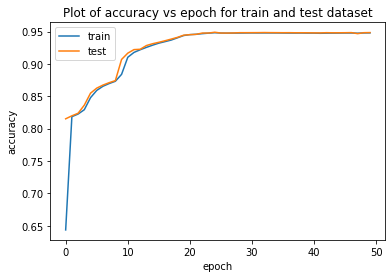

In [ ]:
# Plot of accuracy vs epoch of train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('{}/lstm_multi_accuracy.png'.format(PLOTS_DIR))
plt.show()

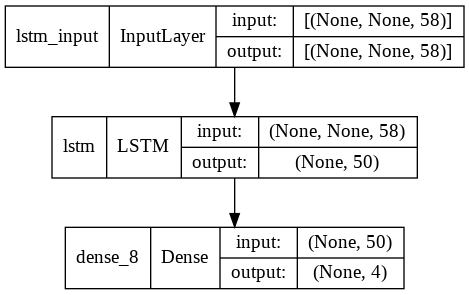

In [ ]:
plot_model(lstm, to_file='{}/lstm_multi.png'.format(PLOTS_DIR), show_shapes=True,)

## 8. Auto Encoder (AE)

In [ ]:
input_dim = transformed_train.shape[1]
encoding_dim = 50

#input layer
input_layer = Input(shape=(input_dim, ))
#encoding layer with 50 neurons
encoder = Dense(encoding_dim, activation="relu")(input_layer)           
#decoding and output layer
output_layer = Dense(input_dim, activation='softmax')(encoder)

In [ ]:
# creating model with input, encoding, decoding, output layers
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# defining loss function, optimizer, metrics and then compiling model
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 58)]              0         
                                                                 
 dense_4 (Dense)             (None, 50)                2950      
                                                                 
 dense_5 (Dense)             (None, 58)                2958      
                                                                 
Total params: 5,908
Trainable params: 5,908
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(transformed_train, transformed_train, epochs=100, batch_size=500, validation_data=(transformed_test, transformed_test)).history

Epoch 1/100
234/234 [==============================] - 2s 6ms/step - loss: 0.0773 - accuracy: 0.4025 - val_loss: 0.0653 - val_accuracy: 0.6387
Epoch 2/100
234/234 [==============================] - 1s 5ms/step - loss: 0.0695 - accuracy: 0.3170 - val_loss: 0.0645 - val_accuracy: 0.4132
Epoch 3/100
234/234 [==============================] - 1s 5ms/step - loss: 0.0690 - accuracy: 0.1958 - val_loss: 0.0633 - val_accuracy: 0.2890
Epoch 4/100
234/234 [==============================] - 1s 5ms/step - loss: 0.0687 - accuracy: 0.1924 - val_loss: 0.0628 - val_accuracy: 0.2252
Epoch 5/100
234/234 [==============================] - 1s 5ms/step - loss: 0.0683 - accuracy: 0.1861 - val_loss: 0.0624 - val_accuracy: 0.2069
Epoch 6/100
234/234 [==============================] - 1s 5ms/step - loss: 0.0682 - accuracy: 0.1861 - val_loss: 0.0624 - val_accuracy: 0.2695
Epoch 7/100
234/234 [==============================] - 1s 5ms/step - loss: 0.0682 - accuracy: 0.2127 - val_loss: 0.0624 - val_accuracy: 0.1862

In [ ]:
#test_results = autoencoder.evaluate(transformed_test, transformed_test, verbose=1)
#print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

In [ ]:
# calculating reconstruction error 
predictions = autoencoder.predict(transformed_test)
mse = np.mean(np.power(transformed_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': Y_test})
error_df = error_df.reset_index()
error_df

,index,reconstruction_error,true_class
0,0,0.026540,0
1,1,0.024212,0
2,2,0.048621,3
3,3,0.059964,1
4,4,0.046986,1
...,...,...,...
20649,22538,0.073647,0
20650,22539,0.054411,3
20651,22540,0.071851,3
20652,22541,0.071848,0


In [ ]:
i_dim = predictions.shape[1]

#input layer
i_layer = Input(shape=(i_dim, ))
#hidden layer with 50 neurons
fvector = Dense(50, activation="sigmoid")(i_layer)                    
#doutput layer
o_layer = Dense(4, activation='sigmoid')(fvector)

In [ ]:
# creating model with input, encoding, decoding, output layers
ae_classifier = Model(inputs=i_layer, outputs=o_layer)

# defining loss function, optimizer, metrics and then compiling model
ae_classifier.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
y_test

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [ ]:
his = ae_classifier.fit(predictions, y_test, epochs=100, batch_size=500).history

Epoch 1/100
42/42 [==============================] - 0s 5ms/step - loss: 0.3203 - accuracy: 0.6979
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 0.3200 - accuracy: 0.6982
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3197 - accuracy: 0.6980
Epoch 4/100
42/42 [==============================] - 0s 5ms/step - loss: 0.3194 - accuracy: 0.6986
Epoch 5/100
42/42 [==============================] - 0s 5ms/step - loss: 0.3192 - accuracy: 0.6976
Epoch 6/100
42/42 [==============================] - 0s 5ms/step - loss: 0.3189 - accuracy: 0.6987
Epoch 7/100
42/42 [==============================] - 0s 5ms/step - loss: 0.3186 - accuracy: 0.6978
Epoch 8/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3183 - accuracy: 0.6978
Epoch 9/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3180 - accuracy: 0.6979
Epoch 10/100
42/42 [==============================] - 0s 5ms/step - loss: 0.3178 - accuracy: 0.6980
Epoch 11/

In [ ]:
preds = ae_classifier.predict(transformed_test).argmax(axis=1)
print(classification_report(preds, Y_test))

              precision    recall  f1-score   support

           0       0.66      0.90      0.76      5015
           1       0.41      0.49      0.45      1681
           2       0.95      0.37      0.53      5438
           3       0.77      0.88      0.82      8520

    accuracy                           0.72     20654
   macro avg       0.70      0.66      0.64     20654
weighted avg       0.76      0.72      0.70     20654



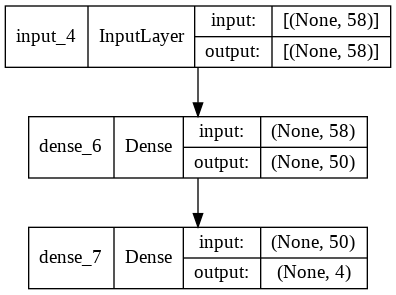

In [ ]:
plot_model(ae_classifier, to_file='{}/ae_classifier_multi.png'.format(PLOTS_DIR), show_shapes=True,)

In [ ]:
numerical_cols = multi_data.select_dtypes(include='number').columns.to_list()
